In [1]:
#!/usr/bin/env python
# coding: utf-8

# python ./pivector.py --env=cenp --gamma=0.997 --noise=0.35 --seed=123

# In[1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import random
import os
import os.path
import argparse
import sys

import gym
gym.logger.set_level(40) # remove gym warning about float32 bound box precision

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt


# In[2]:


import common.env_lib
from common.env_utils import task3_plot
from common.rl_lib import (off_ReplayBuffer, 
                           ENoise, 
                           ValueNetwork,
                           PolicyNetwork, 
                           nn_update2)


# # In[3]:
# parser = argparse.ArgumentParser()
# # parser.add_argument("--env", default="csense", type=str, help="Environment. Specified in ./common/env_lib.py")
# parser.add_argument("--gamma", default=0.996, type=float, help="Discount Factor")
# parser.add_argument("--noise", default=0.8, type=float, help="Action Noise")
# parser.add_argument("--seed", default=238, type=int, help="Set seed [default: 238]")


# args = parser.parse_args()


# # arguments
# seed      = args.seed
# env_name  = 'sensetx'
# GAMMA     = args.gamma
# max_noise = args.noise

seed      = 382084
env_name  = 'sensetx'
GAMMA     = 0.997
max_noise = 0.7

intrp_no  = 4 # no. of actions to interpolate to including greedy actions

# In[4]:


# set seed
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# In[5]:

################################################################################
# If using GPU
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

################################################################################
# Setting up environment base
experiment = "3task_g" + str(GAMMA) + "-n" + str(max_noise) + "-random_pref" + "-intrp" + str(intrp_no)
env = eval("common.env_lib." + env_name + "()")
################################################################################
# Setup Neural Networks

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_lr  = 1e-3
policy_lr = 1e-4

SOFT_TAU=1e-2

batch_size  = 128
replay_buffer_size = 1_000_000
replay_buffer = off_ReplayBuffer(replay_buffer_size)

# Make model
sense_policy_net        = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)
tx_policy_net           = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)
enp_policy_net          = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)

target_sense_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_enp_policy_net   = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_tx_policy_net    = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)


sense_value_net        = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
enp_value_net          = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
tx_value_net           = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)

target_sense_value_net = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_enp_value_net   = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_tx_value_net    = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)

sense_value_optimizer  = optim.Adam(sense_value_net.parameters(),  lr=value_lr)
sense_policy_optimizer = optim.Adam(sense_policy_net.parameters(), lr=policy_lr)

enp_value_optimizer  = optim.Adam(enp_value_net.parameters(),  lr=value_lr)
enp_policy_optimizer = optim.Adam(enp_policy_net.parameters(), lr=policy_lr)

tx_value_optimizer  = optim.Adam(tx_value_net.parameters(),  lr=value_lr)
tx_policy_optimizer = optim.Adam(tx_policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()
################################################################################
# Setup experiment parameters
exp_train_log ={}

env_location = 'tokyo'
exp_train_log[env_location] = {}    


START_YEAR = 1995
NO_OF_YEARS = 1
timeslots_per_day = 24
REQ_TYPE = "dummy"
prediction_horizon = 10*timeslots_per_day
henergy_mean= 0.13904705134356052 # 10yr hmean for tokyo
################################################################################
# Set up tags/folders

# Tags
env_tag = env_name + '_t' + str(timeslots_per_day) + '_' + REQ_TYPE
model_tag = experiment +'-'+str(seed)

# experiment tag
# name of folder to save models and results
exp_tag = env_tag  + "-" + experiment 

# experiment+seed tag
# tensorboard tag / model filename
tag     = exp_tag + '-' + str(seed) 
print("TensorBoard TAG: ",tag)

# Folders
cur_folder = os.getcwd()
# Tensorboard Folder
writer_folder = os.path.join(cur_folder, 'runs', exp_tag, tag )
writer = SummaryWriter(log_dir=writer_folder)

# Folder to save models
model_folder = os.path.join(cur_folder,"models", exp_tag)
if not os.path.exists(model_folder):
    os.makedirs(model_folder) 

# Folder/file to save training results
train_results_folder = os.path.join(cur_folder,"results", exp_tag, "train")
if not os.path.exists(train_results_folder): 
        os.makedirs(train_results_folder) 
train_log_file = os.path.join(train_results_folder, tag + '-train.npy')    

# Folder/file to save test results
test_results_folder = os.path.join(cur_folder,"results", exp_tag, "test")
if not os.path.exists(test_results_folder): 
        os.makedirs(test_results_folder) 
test_log_file = os.path.join(test_results_folder, tag + '-test.npy')  

################################################################################
# Start setup        
episode = 0
frame_idx = 0
# eval_states = None # will be populated with held-out states

# # evaluate Q-values of random states
# NO_OF_STATES_TO_EVALUATE = timeslots_per_day*20 # how many states to sample to evaluate
# EVAL_FREQ = prediction_horizon # how often to evaluate

TensorBoard TAG:  sensetx_t24_dummy-3task_g0.997-n0.7-random_pref-intrp4-382084


In [3]:
# env.set_env('tokyo', 1995, timeslots_per_day, 
#                 REQ_TYPE, offset=timeslots_per_day/2,
#                 p_horizon=prediction_horizon,
#                 hmean=henergy_mean)
# state = env.reset()

# state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

# with torch.no_grad():
#     state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

#     # sense_model: get action and q-value
#     raw_sense_action_tensor = sense_policy_net(state_tensor)
#     sense_value = sense_value_net(state_tensor, raw_sense_action_tensor).cpu().item()
#     raw_sense_action = raw_sense_action_tensor.cpu().numpy().squeeze()

#     # tx_model: get action and q-value
#     raw_tx_action_tensor = tx_policy_net(state_tensor)
#     tx_value = tx_value_net(state_tensor, raw_tx_action_tensor).cpu().item()
#     raw_tx_action = raw_tx_action_tensor.cpu().numpy().squeeze()

#     # enp_model: get action and q-value
#     raw_enp_action_tensor = enp_policy_net(state_tensor)
#     enp_value = enp_value_net(state_tensor, raw_enp_action_tensor).cpu().item()
#     raw_enp_action = raw_enp_action_tensor.cpu().numpy().squeeze()

# # Find two intermediate actions
# intrp_actions1 = np.linspace(raw_sense_action,raw_tx_action,num=intrp_no)[1:-1]
# intrp_actions2 = np.linspace(raw_sense_action,raw_enp_action,num=intrp_no)[1:-1]
# intrp_actions3 = np.linspace(raw_tx_action,raw_enp_action,num=intrp_no)[1:-1]
# centroid = (raw_sense_action+raw_tx_action+raw_enp_action)/3
# intrp_actions = np.vstack((raw_sense_action,raw_tx_action,raw_enp_action,
#                            intrp_actions1, intrp_actions2, intrp_actions3,centroid))

# # Convert intrp_actions to action
# intrp_action_tensor = torch.FloatTensor(intrp_actions).to(device)
# batch_state_tensor = torch.FloatTensor([state]*((intrp_no-2)*3+4)).to(device)

# # Get the q-values from sense and enp models for the intrp_actions
# intrp_sense_value = sense_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
# intrp_tx_value = tx_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
# intrp_enp_value = enp_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()


Year:	 1995
Avg. Supply: 	 0.12686208471286678
Avg sense reward:	 0.9460483966485299
Avg tx    reward:	 0.5775498580864652
Avg enp   reward:	 0.8704978893373183
Downtimes:	 5


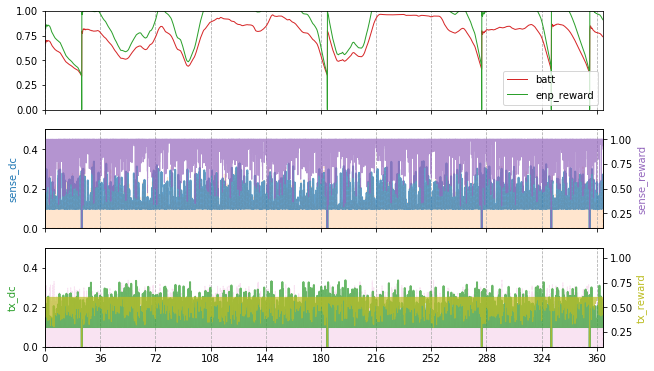

**********************************************************************



In [4]:
################################################################################
# Start training    
for year in range(START_YEAR, START_YEAR+NO_OF_YEARS):
    exp_noise = ENoise(env.action_space, 
                       max_sigma=max_noise, 
                       min_sigma=0.01, 
                       decay_period=30*timeslots_per_day)
    
    env.set_env(env_location, year, timeslots_per_day, 
                REQ_TYPE, offset=timeslots_per_day/2,
                p_horizon=prediction_horizon,
                hmean=henergy_mean)
    state = env.reset()
    reward_rec = []
    ep_done_rec = []
    episode_reward = 0
    done = False
    counter = 0 # record of number of steps in the environment. Required to keep a finite episode length

    while not done:
        # generate 3 preferences (sense, tx and enp) such that they sum to 1
        pref = np.random.random(3)
        pref /= pref.sum()
        pref = tuple(pref)

        writer.add_scalar("Preference/Preference[0]", pref[0], frame_idx)
        writer.add_scalar("Preference/Preference[1]", pref[1], frame_idx)
        writer.add_scalar("Preference/Preference[2]", pref[2], frame_idx)

        if env.RECOVERY_MODE:
            no_action = (0,0)            
            next_state, reward, done, _ = env.step(no_action)
#             writer.add_scalar("iAction/intrp_actions[0]", no_action, frame_idx)
#             writer.add_scalar("iAction/intrp_actions[1]", no_action, frame_idx)
#             writer.add_scalar("iAction/intrp_actions[2]", no_action, frame_idx)
#             writer.add_scalar("iAction/intrp_actions[3]", no_action, frame_idx)
            
            tot_reward = pref[0]*reward[0] + pref[1]*reward[1] +  pref[2]*reward[2]
            reward_rec.append(tot_reward)
            writer.add_scalar("Reward/sense_reward", reward[0], frame_idx)        
            writer.add_scalar("Reward/tx_reward", reward[1], frame_idx)        
            writer.add_scalar("Reward/enp_reward", reward[2], frame_idx)     

            ep_done = done or env.RECOVERY_MODE
            ep_done_rec.append(ep_done)
            state = next_state
            frame_idx +=1
            counter = 0

        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

                # sense_model: get action and q-value
                raw_sense_action_tensor = sense_policy_net(state_tensor)
                sense_value = sense_value_net(state_tensor, raw_sense_action_tensor).cpu().item()
                raw_sense_action = raw_sense_action_tensor.cpu().numpy().squeeze()

                # tx_model: get action and q-value
                raw_tx_action_tensor = tx_policy_net(state_tensor)
                tx_value = tx_value_net(state_tensor, raw_tx_action_tensor).cpu().item()
                raw_tx_action = raw_tx_action_tensor.cpu().numpy().squeeze()

                # enp_model: get action and q-value
                raw_enp_action_tensor = enp_policy_net(state_tensor)
                enp_value = enp_value_net(state_tensor, raw_enp_action_tensor).cpu().item()
                raw_enp_action = raw_enp_action_tensor.cpu().numpy().squeeze()

            # Find two intermediate actions
            intrp_actions1 = np.linspace(raw_sense_action,raw_tx_action,num=intrp_no)[1:-1]
            intrp_actions2 = np.linspace(raw_sense_action,raw_enp_action,num=intrp_no)[1:-1]
            intrp_actions3 = np.linspace(raw_tx_action,raw_enp_action,num=intrp_no)[1:-1]
            centroid = (raw_sense_action+raw_tx_action+raw_enp_action)/3
            intrp_actions = np.vstack((raw_sense_action,raw_tx_action,raw_enp_action,
                                       intrp_actions1, intrp_actions2, intrp_actions3,centroid))

            # Convert intrp_actions to action
            intrp_action_tensor = torch.FloatTensor(intrp_actions).to(device)
            batch_state_tensor = torch.FloatTensor([state]*((intrp_no-2)*3+4)).to(device)

            # Get the q-values from sense and enp models for the intrp_actions
            intrp_sense_value = sense_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
            intrp_tx_value = tx_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
            intrp_enp_value = enp_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()


            # Calculate the node utility for all intrp_actions
            final_value = pref[0]*intrp_sense_value + pref[1]*intrp_tx_value + pref[2]*intrp_enp_value

            # final_action is the action with the maximum final_value
            final_raw_action = intrp_actions[final_value.argmax()]
            noisy_action = exp_noise.get_action(final_raw_action, t=0)            
            tr_action = (noisy_action*0.5 + 0.5)
            next_state, reward, done, _ = env.step(tr_action)
            
#             writer.add_scalar("iAction/intrp_actions[0]", intrp_actions[0], frame_idx)
#             writer.add_scalar("iAction/intrp_actions[1]", intrp_actions[1], frame_idx)
#             writer.add_scalar("iAction/intrp_actions[2]", intrp_actions[2], frame_idx)
#             writer.add_scalar("iAction/intrp_actions[3]", intrp_actions[3], frame_idx)
            
#             writer.add_scalar("iAction_Value/Q-Value[0]", final_value[0], frame_idx)
#             writer.add_scalar("iAction_Value/Q-Value[1]", final_value[1], frame_idx)
#             writer.add_scalar("iAction_Value/Q-Value[2]", final_value[2], frame_idx)
#             writer.add_scalar("iAction_Value/Q-Value[3]", final_value[3], frame_idx)
            
            writer.add_scalar("Final/Final Sense Action", final_raw_action[0], frame_idx)
            writer.add_scalar("Final/Final Tx Action", final_raw_action[1], frame_idx)

            writer.add_scalar("Final/Final Action Value", max(final_value), frame_idx)
            
            tot_reward = pref[0]*reward[0] + pref[1]*reward[1] +  pref[2]*reward[2]
            reward_rec.append(tot_reward)
            writer.add_scalar("Reward/sense_reward", reward[0], frame_idx)        
            writer.add_scalar("Reward/tx_reward", reward[1], frame_idx)        
            writer.add_scalar("Reward/enp_reward", reward[2], frame_idx)     
           
            
            ep_done = done or env.RECOVERY_MODE or (counter==prediction_horizon-1)
            ep_done_rec.append(ep_done)

            
            replay_buffer.push(state, final_raw_action, reward, next_state, ep_done, pref)

            if len(replay_buffer) > batch_size:
                b_state, b_action, b_reward, b_next_state, b_done, b_pref = replay_buffer.sample(batch_size)
                b_sense_reward = np.array([r[0] for r in b_reward])
                b_tx_reward    = np.array([r[1] for r in b_reward])
                b_enp_reward   = np.array([r[2] for r in b_reward])
                
                b_sense_pref = np.array([pref[0] for p in b_pref])
                b_tx_pref    = np.array([pref[1] for p in b_pref])
                b_enp_pref   = np.array([pref[2] for p in b_pref])
                
                
                sense_batch = (b_state, b_action, b_sense_reward, b_next_state, b_done, b_sense_pref)
                nn_update2("sense", sense_batch,
                          sense_value_net, target_sense_value_net, sense_policy_net, target_sense_policy_net,
                          sense_value_optimizer, sense_policy_optimizer, value_criterion, device, writer, frame_idx,
                          gamma=GAMMA,
                          min_value=-np.inf, max_value=np.inf,
                          soft_tau=1e-2,
                          policy_clipgrad=0.5, value_clipgrad=0.5)
                
                tx_batch = (b_state, b_action, b_tx_reward, b_next_state, b_done, b_tx_pref)
                nn_update2("tx", tx_batch,
                          tx_value_net, target_tx_value_net, tx_policy_net, target_tx_policy_net,
                          tx_value_optimizer, tx_policy_optimizer, value_criterion, device, writer, frame_idx,
                          gamma=GAMMA,
                          min_value=-np.inf, max_value=np.inf,
                          soft_tau=1e-2,
                          policy_clipgrad=0.5, value_clipgrad=0.5)
                
                enp_batch = (b_state, b_action, b_enp_reward, b_next_state, b_done, b_enp_pref)
                nn_update2("enp", enp_batch,
                          enp_value_net, target_enp_value_net, enp_policy_net, target_enp_policy_net,
                          enp_value_optimizer, enp_policy_optimizer, value_criterion, device, writer, frame_idx,
                          gamma=GAMMA,
                          min_value=-np.inf, max_value=np.inf,
                          soft_tau=1e-2,
                          policy_clipgrad=0.5, value_clipgrad=0.5)
                    
            episode_reward += tot_reward
            frame_idx +=1
            counter +=1
            state = next_state
            
            if ep_done:
                writer.add_scalar("Episode_reward", episode_reward, episode)
                episode_reward = 0 # reset episode reward
                episode +=1 # increase episode count
                counter = 0 # reset episode counter

        
#         if len(replay_buffer) > 3*NO_OF_STATES_TO_EVALUATE and eval_states is None:
#             eval_states, eval_actions, _ ,_ , _ = replay_buffer.sample(NO_OF_STATES_TO_EVALUATE)
#             eval_states = torch.FloatTensor(eval_states).to(device)
#             eval_actions = torch.FloatTensor(eval_actions).unsqueeze(1).to(device)

#         if eval_states is not None and frame_idx % EVAL_FREQ == 0:
#             mean_val = calc_values_of_states(eval_states, eval_actions, value_net, device=device)
#             writer.add_scalar("values_mean", mean_val, frame_idx)
                
     # Log the traces and summarize results
    iteration_result={}

    # Saving traces
#     iteration_result['reward_rec'] = np.array(reward_rec)
    iteration_result['ep_done_rec'] = np.array(ep_done_rec)
    iteration_result['action_log'] = np.array(env.action_log)
    iteration_result['sense_dc_log'] = np.array(env.sense_dc_log)
    iteration_result['tx_dc_log'] = np.array(env.tx_dc_log)
    iteration_result['env_log'] = np.array(env.env_log)
#     iteration_result['eno_log'] = np.array(env.eno_log)
    iteration_result['sense_reward_log'] = np.array(env.sense_reward_log)
    iteration_result['tx_reward_log'] = np.array(env.tx_reward_log)
    iteration_result['enp_reward_log'] = np.array(env.enp_reward_log)

    
    # Summarizing results
    env_log = iteration_result['env_log']

    # Get henergy metrics
    henergy_rec = env_log[:,1]
    avg_henergy = henergy_rec.mean()
    iteration_result['avg_henergy'] = avg_henergy

    # Get req metrics
    req_rec = env_log[:,5]
    req2_rec = env_log[:,6]

    avg_req = 0.5*(req_rec+req2_rec).mean()            
    iteration_result['avg_req'] = avg_req

#     # Get reward metrics
#     # In this case, the reward metrics directly reflect the conformity
#     reward_recx = iteration_result['reward_rec']
#     # negative rewards = -1000 correspond to downtimes
#     # To find average reward, remove negative values
#     index = np.argwhere(reward_recx<0)
#     rwd_recx = np.delete(reward_recx, index)
#     avg_rwd = rwd_recx.mean()
#     iteration_result['avg_rwd'] = avg_rwd

    # Get downtime metrics
    batt_rec = env_log[:,3]
    batt_rec[batt_rec>0.1]=0
    batt_rec[batt_rec!=0]=1
    downtimes = np.count_nonzero(batt_rec[:-1] < batt_rec[1:])
    iteration_result['downtimes'] = downtimes
    # Print summary
    print("Year:\t", year)            
    print("Avg. Supply: \t", avg_henergy)
#     print("Avg. Request: \t", avg_req)
    print("Avg sense reward:\t", np.mean(iteration_result['sense_reward_log']))
    print("Avg tx    reward:\t", np.mean(iteration_result['tx_reward_log']))
    print("Avg enp   reward:\t", np.mean(iteration_result['enp_reward_log']))
    print("Downtimes:\t", downtimes)
    
#     # Plot traces
    task3_plot(iteration_result, timeslots_per_day, START_DAY=0, NO_OF_DAYS_TO_PLOT = 500)
    
    # Store results, traces and summary
    exp_train_log[env_location][year] = iteration_result
    print("*"*70)
    print("")

# In[11]:

In [5]:
################################################################################
# Save Training Results in file
np.save(train_log_file, exp_train_log)


# In[21]:

################################################################################
# display training performance metrics
train_log = exp_train_log[env_location]
print("\n\n***TRAINING PERFORMANCE****")
print("YEAR".ljust(6), "HMEAN".ljust(8), "REQ_MEAN".ljust(8), 
      "SNS_RWD".ljust(8), "TX_RWD".ljust(8), "ENP_RWD".ljust(8), "DOWNTIMES".ljust(9))
for year in list(train_log.keys()):
    iteration_result =  train_log[year]
    
    # Print summarized metrics
    print(year,end=' ')
    sense_avg_rwd = iteration_result['sense_reward_log'].mean()
    tx_avg_rwd = iteration_result['tx_reward_log'].mean()
    enp_avg_rwd = iteration_result['enp_reward_log'].mean()
    total_downtimes = iteration_result['downtimes']
    hmean = iteration_result['avg_henergy']
    reqmean = iteration_result['avg_req']
    sense_dc_mean = iteration_result['sense_dc_log'].mean()
    
    print(f'{hmean:7.3f}',end='  ')
    print(f'{reqmean:7.3f}',end='  ')
    print(f'{sense_avg_rwd:7.3f}',end='  ')
    print(f'{tx_avg_rwd:7.3f}',end='  ')
    print(f'{enp_avg_rwd:7.3f}',end='  ')
    print(f'{total_downtimes:9d}',end='  ')
    print("")

# In[14]:
################################################################################
# Save policy model weights with filename as tag
sense_policy_net_model_file = os.path.join(model_folder, (tag + "-sense_policy.pt"))
torch.save(sense_policy_net.state_dict(), sense_policy_net_model_file)

enp_policy_net_model_file = os.path.join(model_folder, (tag + "-enp_policy.pt"))
torch.save(enp_policy_net.state_dict(), enp_policy_net_model_file)

tx_policy_net_model_file = os.path.join(model_folder, (tag + "-tx_policy.pt"))
torch.save(tx_policy_net.state_dict(), tx_policy_net_model_file)
# In[15]:

################################################################################
# Save value model weights with filename as tag
sense_value_net_model_file = os.path.join(model_folder, (tag + "-sense_value.pt"))
torch.save(sense_value_net.state_dict(), sense_value_net_model_file)

enp_value_net_model_file = os.path.join(model_folder, (tag + "-enp_value.pt"))
torch.save(enp_value_net.state_dict(), enp_value_net_model_file)

tx_value_net_model_file = os.path.join(model_folder, (tag + "-tx_value.pt"))
torch.save(tx_value_net.state_dict(), tx_value_net_model_file)
################################################################################



***TRAINING PERFORMANCE****
YEAR   HMEAN    REQ_MEAN SNS_RWD  TX_RWD   ENP_RWD  DOWNTIMES
1995   0.127    0.136    0.946    0.578    0.870          5  


In [16]:
# In[16]:
# Testing
test_pref_list = [
(0.4,0.1,0.5),
(0.1,0.4,0.5),
(0.7,0.2,0.1),
(0.2,0.7,0.1),
(0.2,0.1,0.7),
(0.1,0.2,0.7),]

# Make model

sense_pnet = sense_policy_net
tx_pnet    = tx_policy_net
enp_pnet   = enp_policy_net

sense_qnet = sense_value_net
tx_qnet    = tx_value_net
enp_qnet   = enp_value_net


sense_pnet.eval()
sense_qnet.eval()
tx_pnet.eval()
tx_qnet.eval()
enp_pnet.eval()
enp_qnet.eval();

env_location_list = ['tokyo']
START_YEAR  = 2005
NO_OF_YEARS = 10

exp_test_log = {} # dictionary to store test results
for env_location in env_location_list:
#     print(env_location)
    exp_test_log[env_location] = {}
    for year in range(START_YEAR, START_YEAR+NO_OF_YEARS):
        exp_test_log[env_location][year]={}
        for pref in test_pref_list:
#             print("\n\nPreference: ", pref)
            exp_test_log[env_location][year][pref]={}
            env.set_env(env_location,year, timeslots_per_day, 
                        REQ_TYPE, offset=timeslots_per_day/2,
                        p_horizon=prediction_horizon,
                        hmean=henergy_mean)    
            state = env.reset()
            reward_rec = []

            intrp_sense_value_rec = []
            intrp_tx_value_rec    = []
            intrp_enp_value_rec   = []
            
            intrp_final_value_rec = []
            intrp_final_action_rec = []

            ep_done_rec = []
            done = False
            while not done:
                if env.RECOVERY_MODE:
                    no_action = (0,0)            
                    next_state, reward, done, _ = env.step(no_action)      
                else:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

                        # sense_model: get action and q-value
                        raw_sense_action_tensor = sense_pnet(state_tensor)
                        sense_value = sense_qnet(state_tensor, raw_sense_action_tensor).cpu().item()
                        raw_sense_action = raw_sense_action_tensor.cpu().numpy().squeeze()

                        # tx_model: get action and q-value
                        raw_tx_action_tensor = tx_pnet(state_tensor)
                        tx_value = tx_qnet(state_tensor, raw_tx_action_tensor).cpu().item()
                        raw_tx_action = raw_tx_action_tensor.cpu().numpy().squeeze()

                        # enp_model: get action and q-value
                        raw_enp_action_tensor = enp_pnet(state_tensor)
                        enp_value = enp_qnet(state_tensor, raw_enp_action_tensor).cpu().item()
                        raw_enp_action = raw_enp_action_tensor.cpu().numpy().squeeze()

                    # Find two intermediate actions
                    intrp_actions1 = np.linspace(raw_sense_action,raw_tx_action,num=intrp_no)[1:-1]
                    intrp_actions2 = np.linspace(raw_sense_action,raw_enp_action,num=intrp_no)[1:-1]
                    intrp_actions3 = np.linspace(raw_tx_action,raw_enp_action,num=intrp_no)[1:-1]
                    centroid = (raw_sense_action+raw_tx_action+raw_enp_action)/3
                    intrp_actions = np.vstack((raw_sense_action,raw_tx_action,raw_enp_action,
                                               intrp_actions1, intrp_actions2, intrp_actions3,centroid))

                    # Convert intrp_actions to action
                    intrp_action_tensor = torch.FloatTensor(intrp_actions).to(device)
                    batch_state_tensor = torch.FloatTensor([state]*((intrp_no-2)*3+4)).to(device)

                    # Get the q-values from sense and enp models for the intrp_actions
                    intrp_sense_value = sense_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
                    intrp_tx_value = tx_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
                    intrp_enp_value = enp_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
                    
                    intrp_sense_value_rec.append(intrp_sense_value)
                    intrp_tx_value_rec.append(intrp_tx_value)
                    intrp_enp_value_rec.append(intrp_enp_value)

                    # Calculate the node utility for all intrp_actions
                    final_value = pref[0]*intrp_sense_value + pref[1]*intrp_tx_value + pref[2]*intrp_enp_value
                    intrp_final_value_rec.append(final_value)

                    # final_action is the action with the maximum final_value
                    final_raw_action = intrp_actions[final_value.argmax()]
                    tr_action = (final_raw_action*0.5 + 0.5)

                    # Execute action
                    next_state, reward, done, _ = env.step(tr_action)
                    
                tot_reward = pref[0]*reward[0] + pref[1]*reward[1] +  pref[2]*reward[2]
                reward_rec.append(tot_reward)
                ep_done = done or env.RECOVERY_MODE
                ep_done_rec.append(ep_done)
                state = next_state

            # Log the traces and summarize results
            iteration_result={}

            # Saving traces
#             iteration_result['reward_rec'] = np.array(reward_rec)
            iteration_result['ep_done_rec'] = np.array(ep_done_rec)
            iteration_result['action_log'] = np.array(env.action_log)
            iteration_result['sense_dc_log'] = np.array(env.sense_dc_log)
            iteration_result['tx_dc_log'] = np.array(env.tx_dc_log)
            iteration_result['env_log'] = np.array(env.env_log)
#             iteration_result['eno_log'] = np.array(env.eno_log)
            iteration_result['sense_reward_log'] = np.array(env.sense_reward_log)
            iteration_result['tx_reward_log'] = np.array(env.tx_reward_log)
            iteration_result['enp_reward_log'] = np.array(env.enp_reward_log)

            iteration_result['intrp_sense_value_rec'] = intrp_sense_value_rec
            iteration_result['intrp_enp_value_rec'] = intrp_enp_value_rec
            iteration_result['intrp_final_value_rec'] = intrp_final_value_rec

            # Summarizing results
            env_log = iteration_result['env_log']

            # Get henergy metrics
            henergy_rec = env_log[:,1]
            avg_henergy = henergy_rec.mean()
            iteration_result['avg_henergy'] = avg_henergy

            # Get req metrics
            req_rec = env_log[:,5]
            req2_rec = env_log[:,6]

            avg_req = 0.5*(req_rec+req2_rec).mean()            
            iteration_result['avg_req'] = avg_req

#             # Get reward metrics
#             # In this case, the reward metrics directly reflect the conformity
#             reward_rec = iteration_result['reward_rec']
#             # negative rewards = -1000 correspond to downtimes
#             # To find average reward, remove negative values
#             index = np.argwhere(reward_rec<0)
#             rwd_rec = np.delete(reward_rec, index)
#             avg_rwd = rwd_rec.mean()
#             iteration_result['avg_rwd'] = avg_rwd

            # Get downtime metrics
            ep_done_rec =  iteration_result['ep_done_rec']
            downtimes = np.count_nonzero(ep_done_rec[:-1] < ep_done_rec[1:]) - 1 # last env done is excluded
            iteration_result['downtimes'] = downtimes

    #         print("Year:\t", year)            
            exp_test_log[env_location][year][pref] = iteration_result
#     print("")

################################################################################
# Save Test Results
np.save(test_log_file, exp_test_log)

# summarize metrics and display
print("\n\n***TEST RESULTS****")
print("Tag:", tag)
print("Seed:", seed)

for pref in test_pref_list:
    print("\n\nPreference: ", pref)
    print("LOCATION".ljust(12), "YEAR".ljust(6), "HMEAN".ljust(8), "REQ_MEAN".ljust(8),  
          "SNS_RWD".ljust(8), "TX_RWD".ljust(8), "ENP_RWD".ljust(8), "DOWNTIMES".ljust(9))
    
    exp_result = exp_test_log
    location_list = list(exp_result.keys())
    for location in location_list:
        yr_list = list(exp_result[location].keys())
        for year in yr_list:
            run_log = exp_result[location][year][pref]
            # Print summarized metrics
            print(location.ljust(12), year, end=' ')
            sense_avg_rwd = run_log['sense_reward_log'].mean()
            tx_avg_rwd = run_log['tx_reward_log'].mean()
            enp_avg_rwd = run_log['enp_reward_log'].mean()

            total_downtimes = run_log['downtimes']
            hmean = run_log['avg_henergy']
            reqmean = run_log['avg_req']

            print(f'{hmean:7.3f}',end='  ')
            print(f'{reqmean:7.3f}',end='  ')
            print(f'{sense_avg_rwd:7.3f}',end='  ')
            print(f'{tx_avg_rwd:7.3f}',end='  ')
            print(f'{enp_avg_rwd:7.3f}',end='  ')
            print(f'{total_downtimes:5d}',end='  ')
            print("")





***TEST RESULTS****
Tag: sensetx_t24_dummy-3task_g0.997-n0.7-random_pref-intrp4-382084
Seed: 382084


Preference:  (0.4, 0.1, 0.5)
LOCATION     YEAR   HMEAN    REQ_MEAN SNS_RWD  TX_RWD   ENP_RWD  DOWNTIMES
tokyo        2005   0.133    0.137    0.994    0.581    0.816      9  
tokyo        2006   0.119    0.133    0.993    0.582    0.813     13  
tokyo        2007   0.136    0.138    0.994    0.577    0.850     11  
tokyo        2008   0.131    0.137    0.995    0.578    0.877     10  
tokyo        2009   0.130    0.136    0.995    0.577    0.891     10  
tokyo        2010   0.138    0.139    0.994    0.575    0.889     11  
tokyo        2011   0.142    0.140    0.995    0.577    0.882      7  
tokyo        2012   0.144    0.140    0.995    0.574    0.890      9  
tokyo        2013   0.148    0.141    0.995    0.575    0.882      8  
tokyo        2014   0.143    0.140    0.995    0.576    0.855     10  


Preference:  (0.1, 0.4, 0.5)
LOCATION     YEAR   HMEAN    REQ_MEAN SNS_RWD  TX_R